In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import itertools
import xgboost as xgb
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_validation import *
from sklearn.grid_search import GridSearchCV

C:\Users\Ali\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Ali\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [67]:
trainSet = pd.read_csv('data/movies_with_image_features.csv')

trainSet = trainSet.set_index('id')
trainSet = trainSet.drop(['popularity'],axis=1)
trainSet = trainSet.drop(['movie_id'],axis=1)

trainSet = trainSet.rename(index=str,columns={'18':'Drama','12':'Adventure','878':'Science Fiction','28':'Action','10751':'Family',
                              '53':'Thriller','35':'Comedy','80':'Crime','9648':'Mystery','14':'Fantasy','27':'Horror',
                              '10749':'Romance','99':'Documentary', '10402':'Music', '36':'History', '10752':'War',
                              '16':'Animation', '37':'Western', '10769':'Foreign', '10770':'TV Movie'})

X = trainSet.drop(['vote_count','vote_average'],axis=1)

In [68]:
# corr_mat=X.corr(method='pearson')
# plt.figure(figsize=(20,10))
# sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

In [69]:
X_train = np.asarray(X.values)
X_std=StandardScaler().fit_transform(X_train)

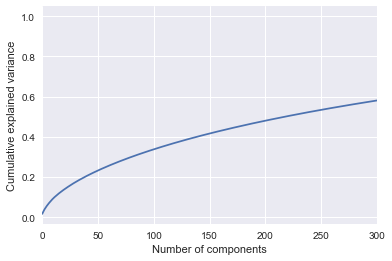

In [70]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,300,10)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [71]:
sklearn_pca=PCA(n_components=300)
X_train=sklearn_pca.fit_transform(X_std)

In [72]:
y = trainSet['vote_average']
X = X_train

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.33,random_state=12)

In [73]:
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [74]:
alphas = [0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100, 200, 1000, 5000,10000]
r_cv = RidgeCV(alphas=alphas)
r_cv.fit(train_X,train_y)
print r_cv.alpha_
print r_cv.score(test_X,test_y)
print mean_squared_error(test_y,r_cv.predict(test_X))

10000.0
0.0550625099248
2.0530784248


In [75]:
l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
en_cv = ElasticNetCV(alphas=alphas,l1_ratio=l1_ratio)
en_cv.fit(train_X,train_y)
print en_cv.alpha_
print en_cv.l1_ratio_
print en_cv.score(test_X,test_y)
print mean_squared_error(test_y,en_cv.predict(test_X))

1.0
0.1
0.0454390763051
2.07398738877


In [76]:
from sklearn.neighbors import KNeighborsRegressor

In [91]:
knn = GridSearchCV(KNeighborsRegressor(),dict(n_neighbors=np.arange(18,25)),cv=5,scoring='neg_mean_squared_error')

In [92]:
knn.fit(train_X,train_y)
print knn.best_params_
print knn.score(test_X,test_y)
print mean_squared_error(test_y,knn.predict(test_X))

{'n_neighbors': 24}
-2.13923538214
2.13923538214


In [93]:
from sklearn.tree import DecisionTreeRegressor

In [94]:
dtree = GridSearchCV(DecisionTreeRegressor(), dict(min_samples_split=[4,16,64,256,1024],min_samples_leaf=[4,16,64,256,1024],splitter=['best','random']),cv=5,scoring='neg_mean_squared_error')

In [95]:
dtree.fit(train_X,train_y)
print dtree.score(test_X,test_y)
print mean_squared_error(test_y,dtree.predict(test_X))

-2.17275045909
2.17275045909


In [96]:
from xgboost import XGBRegressor

In [97]:
# xgb1 = XGBRegressor(learning_rate=0.1,n_estimators=1000,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='reg:linear',scale_pos_weight=1,seed=1)
# def fit(xgb1,trainX,trainY):
#     param = xgb1.get_params()
#     xgbtrain = xgb.DMatrix(trainX,label=trainY.values)
#     cv = xgb.cv(param,xgbtrain,num_boost_round=param['n_estimators'],nfold=5,metrics='mse', early_stopping_rounds=50)
#     xgb1.set_params(n_estimators=cv.shape[0])
#     xgb1.fit(trainX,trainY,eval_metric='mse')

In [99]:
xgb2 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', nthread=4,scale_pos_weight=1,seed=27), 
 param_grid = dict(max_depth=range(1,4),min_child_weight=range(2,5)), scoring='neg_mean_squared_error',iid=False, cv=5)
xgb2.fit(train_X,train_y)
print xgb2.best_params_, xgb2.best_score_
print xgb2.score(test_X,test_y)
print mean_squared_error(test_y,xgb2.predict(test_X))

{'max_depth': 1, 'min_child_weight': 3} -2.18058634787
-2.12106394692
2.12106394692


In [102]:
xgb3 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=1,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', scale_pos_weight=1,seed=27), 
 param_grid = dict(gamma=[i/10.0 for i in range(0,3)]), scoring='neg_mean_squared_error',iid=False, cv=5)
xgb3.fit(train_X,train_y)
print xgb3.best_params_, xgb3.best_score_
print mean_squared_error(test_y,xgb3.predict(test_X))

{'gamma': 0.0} -2.18058634787
2.12106394692


In [104]:
xgb4 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=1,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:linear', scale_pos_weight=1,seed=27), 
 param_grid = dict(subsample=[i/10.0 for i in range(4,8)],colsample_bytree=[i/10.0 for i in range(6,10)]), 
 scoring='neg_mean_squared_error',iid=False, cv=5)
xgb4.fit(train_X,train_y)
print xgb4.best_params_, xgb4.best_score_
print mean_squared_error(test_y,xgb4.predict(test_X))

{'subsample': 0.5, 'colsample_bytree': 0.7} -2.15981576897
2.14199855918


In [105]:
xgb5 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=1,
 min_child_weight=3, gamma=0, subsample=0.5, colsample_bytree=0.8,
 objective= 'reg:linear', scale_pos_weight=1,seed=27), 
 param_grid = dict(subsample=[i/100.0 for i in range(45,60,5)],colsample_bytree=[i/100.0 for i in range(65,80,5)]), 
 scoring='neg_mean_squared_error',iid=False, cv=5)
xgb5.fit(train_X,train_y)
print xgb5.best_params_, xgb5.best_score_
print mean_squared_error(test_y,xgb5.predict(test_X))

{'subsample': 0.5, 'colsample_bytree': 0.7} -2.15981576897
2.14199855918


In [106]:
xgb6 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=1,
 min_child_weight=3, gamma=0, subsample=0.5, colsample_bytree=0.7,
 objective= 'reg:linear', scale_pos_weight=1,seed=27), 
 param_grid = dict(reg_alpha=[1e-5, 1e-2, 0.1, 1, 100],reg_lambda=[1e-5, 1e-2, 0.1, 1, 100]), 
 scoring='neg_mean_squared_error',iid=False, cv=5)
xgb6.fit(train_X,train_y)
print xgb6.best_params_, xgb6.best_score_
print mean_squared_error(test_y,xgb6.predict(test_X))

{'reg_alpha': 1e-05, 'reg_lambda': 100} -2.15404736048
2.12108079099


In [107]:
xgb7 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=140, max_depth=1,
 min_child_weight=3, gamma=0, subsample=0.5, colsample_bytree=0.7,
 objective= 'reg:linear', scale_pos_weight=1,seed=27), 
 param_grid = dict(reg_alpha=[0, 1e-6,1e-5,1e-4],reg_lambda=[0, 10,100,1000]), 
 scoring='neg_mean_squared_error',iid=False, cv=5)
xgb7.fit(train_X,train_y)
print xgb7.best_params_, xgb7.best_score_
print mean_squared_error(test_y,xgb7.predict(test_X))

{'reg_alpha': 1e-05, 'reg_lambda': 100} -2.15404736048
2.12108079099


In [108]:
xgb8 = XGBRegressor( learning_rate=0.01, n_estimators=5000, max_depth=1,
 min_child_weight=3, gamma=0, subsample=0.5, colsample_bytree=0.7,
 reg_alpha=1e-5,reg_lambda=100,
 objective= 'reg:linear', scale_pos_weight=1)
# fit(xgb8,train_X,train_y)
xgb8.fit(train_X,train_y)
print xgb8.score(train_X,train_y)
print mean_squared_error(test_y,xgb8.predict(test_X))

0.329822315455
2.1192537531


In [109]:
preds = np.array(xgb8.predict(test_X))
mean_squared_error(test_y,preds)

2.1192537530973588

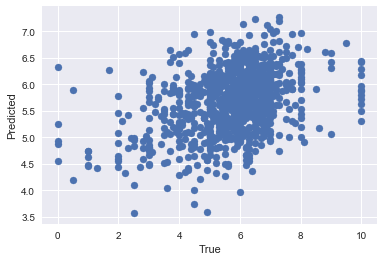

In [110]:
plt.scatter(test_y,pred)
plt.xlabel('True') 
plt.ylabel('Predicted') 

In [64]:
pred = pd.DataFrame(preds,index = test_y.index,columns=['prediction'])

In [65]:
out = pd.concat((pred,test_y),axis=1)
out.to_csv('data/predictions4.csv')

In [29]:
preds = []
for i in range(50):
    xgb8 = XGBRegressor( learning_rate=0.01, n_estimators=5000, max_depth=3,
     min_child_weight=5, gamma=0.6, subsample=0.7, colsample_bytree=0.6,
     reg_alpha=1,reg_lambda=.1, seed=i,
     objective= 'reg:linear', scale_pos_weight=1)
    # fit(xgb8,train_X,train_y)
    xgb8.fit(train_X,train_y)
    print 'R{}:'.format(i),xgb8.score(train_X,train_y)
    p = xgb8.predict(test_X)
    print 'R{}:'.format(i),mean_squared_error(test_y,p)
    preds.append(p)

R0: 0.992196435524
R0: 0.945741092899
R1: 0.992235229955
R1: 0.948443803163
R2: 0.992329327706
R2: 0.937319532393
R3: 0.992266152093
R3: 0.966963939106
R4: 0.992184522311
R4: 0.93446257051
R5: 0.992317590254
R5: 0.94699663854
R6: 0.992279615938
R6: 0.940243603897
R7: 0.992255004221
R7: 0.951063955963
R8: 0.992217741315
R8: 0.945246414856
R9: 0.992249482092
R9: 0.950922479742
R10: 0.992215724846
R10: 0.947276227882
R11: 0.992235552283
R11: 0.942383423452
R12: 0.992255257785
R12: 0.940512859478
R13: 0.99221303332
R13: 0.929386194273
R14: 0.992308084381
R14: 0.947533926131
R15: 0.992256344326
R15: 0.944568696513
R16: 0.992222797376
R16: 0.960485952462
R17: 0.992283516397
R17: 0.937703279671
R18: 0.992245567723
R18: 0.943280051435
R19: 0.99223788137
R19: 0.963977002303
R20: 0.992262077887
R20: 0.935197262007
R21: 0.992256161588
R21: 0.947468721716
R22: 0.992231461889
R22: 0.93871963719
R23: 0.992269738618
R23: 0.942495329102
R24: 0.992276129794
R24: 0.959476163413
R25: 0.992240997302
R25: 

In [38]:
preds = np.array(preds)
mean_squared_error(test_y,preds.mean(axis=0))

0.93312691776069656

In [56]:
pred = pd.DataFrame(preds.mean(axis=0),index = test_y.index,columns=['prediction'])

In [58]:
out = pd.concat((pred,test_y),axis=1)
out.to_csv('data/predictions5.csv')

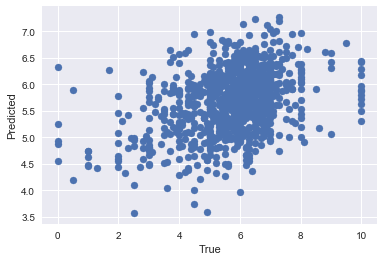

In [66]:
plt.scatter(test_y,pred)
plt.xlabel('True') 
plt.ylabel('Predicted') 